In [579]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, transpile
from qiskit_aer import Aer
import itertools




In [580]:
simulator = Aer.get_backend('aer_simulator_statevector')

In [581]:
n = 7

In [582]:
import random
num_clauses = np.random.randint(3, 3*n)  # Random number of clauses between 3 and 10


def random_boolean_function(num_vars, num_clauses, clause_size_range=(2, n)):
    """
    Generate a random Boolean function in CNF form.

    Args:
        num_vars (int): Number of variables.
        num_clauses (int): Number of clauses.
        clause_size_range (tuple): Min and max size of each clause.

    Returns:
        list of list of int: CNF clauses.
    """
    clauses = []
    for _ in range(num_clauses):
        clause_size = random.randint(*clause_size_range)
        vars_in_clause = random.sample(range(1, num_vars + 1), clause_size)
        clause = [var if random.choice([True, False]) else -var for var in vars_in_clause]
        clauses.append(clause)
    return clauses



In [583]:

Bfunc = random_boolean_function(n, num_clauses)
print("Random Bfunc:", Bfunc)

Random Bfunc: [[7, -6], [6, 5, -1, -7], [-4, 3, 1], [-7, 3, 5, 6, -4, -2], [1, 3, 6], [-2, -7], [3, -1], [-6, -7, -3], [4, 3, -1, 2, -6], [3, 1, -4, 2, 7], [-3, -7, 6], [5, -6, -1], [3, 7, -6, 4]]


In [584]:
# Remove duplicate clauses (ignoring order and sign)
seen = set()
unique_Bfunc = []
for clause in Bfunc:
    key = tuple(sorted(clause))
    if key not in seen:
        seen.add(key)
        unique_Bfunc.append(clause)
Bfunc = unique_Bfunc

In [585]:
#sorting
for i in Bfunc:
    i.sort(key=lambda x: abs(x))
Bfunc.sort(key=lambda clause: sorted([abs(l) for l in clause]))

Bfunc.sort(key=lambda x: len(x))

print("Bfunc:", Bfunc)

Bfunc: [[-1, 3], [-2, -7], [-6, 7], [1, 3, -4], [1, 3, 6], [-1, 5, -6], [-3, -6, -7], [-3, 6, -7], [-1, 5, 6, -7], [3, 4, -6, 7], [-1, 2, 3, 4, -6], [1, 2, 3, -4, 7], [-2, 3, -4, 5, 6, -7]]


In [586]:
def clause_circ(clause, ar, qc):
    """
    Constructs a quantum circuit to mark the states that satisfy a given clause using an ancilla qubit.

    Args:
        clause (list of int): The clause represented as a list of literals (positive for variable, negative for negation).
        ar (AncillaRegister): Ancilla register (should have at least one qubit).
        qc (QuantumCircuit): The quantum circuit to which the clause marking is applied.

    This function:
    - Resets the ancilla qubit.
    - Applies X gates to positive literals to flip them, so all controls are on |1⟩.
    - Applies a multi-controlled X (MCX) gate with all clause qubits as controls and the ancilla as the target.
    - Undoes the X gates on positive literals to restore the original state.
    """
    # Reset the ancilla qubit before marking
    qc.reset(ar[0])
    
    # Apply X gates to positive literals to flip them (so all controls are on |1>)
    for l in clause:
        if l > 0:
            qc.x(l - 1)

    # Apply multi-controlled X with all clause qubits as controls and ancilla as target
    qc.mcx(list(np.abs(clause) - [1]), ar[0])
    
    # Undo the X gates on positive literals to restore original state
    for l in clause:
        if l > 0:
            qc.x(l - 1)

In [587]:
def intersection(C,Ci,l,li,app_clause,Qci):
    """
    Finds an intersection between two clauses C and Ci.

    Args:
        C (list): The current clause being processed.
        Ci (list): Another clause to check for intersection.
        l (list): List of literals processed so far.
        li (int): Index of the current literal.
        app_clause (list): List of clauses already applied/intersected.
        Qci (list): Queue/list of intersections for the current clause.

    Returns:
        list or None or int: Returns a pair [index, clause] if a valid intersection is found,
        None if no intersection is possible, or -1 if intersection is invalid.
    """
    # This function finds an intersection between two clauses C and Ci,
    # given the current list of literals l, the literal index li, the list of applied clauses app_clause, and Qci.
    # It returns a pair [index, clause] or None/-1 if no valid intersection is found.

    cvci=[]

    for i in Ci:
        if abs(i) not in np.abs(cvci):        
            cvci.append(i)
        
    
    for i in Ci :
        if i in l and Ci not in app_clause:
            return [abs(i)-1,cvci]
    
    x=li+1

    if x not in Ci:
        x=-x           

    
    for j,Cj in enumerate(app_clause):
        if Cj==Ci:
            for i in Ci:
                if i != Qci[j][0] and not(abs(i) in np.abs(l) and i not in l):
                    return [abs(i)-1,cvci]
           
    if abs(x) not in np.abs(l):    
        return [abs(x)-1,cvci]


    for i in Ci:
        if abs(i) not in np.abs(l):
            return [abs(i)-1,cvci]



In [588]:
def find(C,lit,Bf, count,Qci,aq,n,f=0,l=0,app_clause=[]):
    """
    Recursively finds intersections between clauses to build a queue of intersecting literals and clauses.

    Args:
        C (list): The current clause being processed.
        lit (int): The current literal being considered.
        Bf (list): List of previous clauses (subset of all clauses).
        count (int): Counter for recursion or tracking (not always used).
        Qci (list): Queue/list of intersections for the current clause.
        aq (list): List of applied/intersected clauses so far.
        n (int): Number of variables.
        f (int, optional): Depth or recursion flag (default 0).
        l (list or int, optional): List of literals processed so far (default 0, which is replaced by [lit]).
        app_clause (list, optional): List of clauses already applied/intersected (default empty).

    Returns:
        tuple: (Qci, app_clause) - Updated queue of intersections and applied clauses.
    """
    
    # Initialize intersection variable
    inter = None   

    # If l (list of literals) is not provided, start with the current literal
    if l == 0:
        l = [lit]
    # If app_clause (applied clauses) is not provided, start with the current clause
    if app_clause == []:
        app_clause = [C] 
    
    # If the list of literals exceeds the number of variables, return (out of range)
    if len(l) > n:
        print('out of range', 'C', C, 'lit', lit, 'l', l, 'Qci', Qci)
        return Qci, app_clause

    # Iterate over previous clauses in Bf
    for i, Ci in enumerate(Bf):
        flag = 0
        # Only process up to the length of aq (applied clause queue)
        if i >= len(aq):
            break
        # Check each literal in the clause
        for m in Ci:
            # If the literal matches in absolute value but is not the same (opposite sign) and clauses are different
            if (abs(m) == abs(lit) and m != lit and C != Ci):
                # Try to find intersection between clauses
                inter = intersection(C, Ci, l, aq[i][1][0], app_clause, Qci)            
                if inter is None:
                    Qci[0] = -len(aq) - 1
                    return Qci, app_clause
                # If intersection is invalid, skip
                if (inter == -1):
                    continue
                # If intersection already in Qci, skip
                if (inter in Qci):
                    continue
                # Add the intersected clause to applied clauses
                app_clause.append(Ci)
                Qci[0] += 1
                Qci += [inter]

                # Prepare next literal to process
                x = inter[0] + 1
                if x not in inter[1]:
                    x = -x
                
                y = aq[i][1][0] + 1
                if y not in inter[1]:
                    y = -y
            
                # If x is not in the list of literals, add and recurse
                if x not in l:
                    l += [x]    
                    Qci, app_clause = find(Ci, l[-1], Bf, count, Qci, aq, n, f=f+1, l=l, app_clause=app_clause)
                else:
                    # Otherwise, recurse with x
                    Qci, app_clause = find(Ci, x, Bf, count, Qci, aq, n, f=f+1, l=l, app_clause=app_clause)
                break
            
    # Return the updated Qci and app_clause
    return Qci, app_clause


In [589]:
def find_min(Qi,max=1000):
    """
    Find the sublist in Qi with the minimal positive first element.

    Args:
        Qi (list of lists): Each sublist starts with an integer (typically a cost or marker).
        max (int, optional): Upper bound for the minimum search (default 1000).

    Returns:
        list: The sublist from Qi with the smallest positive first element, or an empty list if none found.
    """
    mini=max
    Min=[]  
    for i in Qi:
        if i[0]>=1 and i[0]<mini:
            mini=i[0]
            Min=i
            if min==1:
                break
    return Min


In [590]:

def Sat_solver(Bf,n):
    """
    Quantum SAT Solver: Constructs a quantum circuit to solve a Boolean SAT problem in CNF form.

    Args:
        Bf (list of list of int): The Boolean function in CNF, where each clause is a list of literals.
        n (int): Number of variables.

    Returns:
        tuple: (QuantumCircuit, complexity, cxcount)
            - QuantumCircuit: The constructed quantum circuit for the SAT problem.
            - complexity: The sum of minimal intersections per clause (or None if unsatisfiable).
            - cxcount: The number of CX gates applied (as a measure of circuit complexity).
    """
    
    
    
    qr=QuantumRegister(n, 'q')
    cr=ClassicalRegister(n, 'c')
    ar=AncillaRegister(1, 'a')
    qc=QuantumCircuit(qr, cr, ar)
    
    qc.h(qr)
    
    aq = []
    complexity = 1
                
    count=0
    for a, C in enumerate(Bf):
        
        Qi= [[-1-n] for _ in range(n)]
        
        for l in C:
            Qi[abs(l)-1].append([abs(l)-1] + [C])
            Qi[abs(l)-1][0]=1
            if aq==[]:
                break
            Qi[abs(l)-1]= find(C, l, Bf[:a], count, Qi[abs(l)-1], aq,n,f=0,l=0,app_clause=[])[0]
            if Qi[abs(l)-1][0]==1:
                break
            

        aq.append(find_min(Qi))
        if aq[-1]==[]:
            for i in Qi:
                if len(i)>1:
                    aq[-1]=i
                    break
            
            if aq[-1]==[]:
                print('No solution found')
                complexity= None
            complexity = None
            

        for i in aq[-1][1:]:        
            clause_circ(i[1], ar, qc) #mark the states using ancilla
            qc.cx(ar[0], i[0])  #remove the marked states 
            count+=1
        qc.barrier()
        
    qc.measure(qr, cr)
    print('aq:', aq)
    if complexity is not None:
        complexity = sum(i[0] for i in aq)
    print('Complexity:', complexity)
    print('cxcount',count)
    return qc,complexity,count

In [591]:
sol=Sat_solver(Bfunc, n)
circ=sol[0]
complexity=sol[1]
cxcount=sol[2]
print(Bfunc)
# circ.draw('mpl')

aq: [[1, [0, [-1, 3]]], [1, [1, [-2, -7]]], [1, [5, [-6, 7]]], [1, [2, [1, 3, -4]]], [1, [2, [1, 3, 6]]], [1, [4, [-1, 5, -6]]], [2, [5, [-3, -6, -7]], [2, [1, 3, 6]]], [7, [6, [-3, 6, -7]], [5, [-6, 7]], [2, [1, 3, 6]], [5, [-3, -6, -7]], [0, [1, 3, 6]], [2, [-1, 3]], [5, [-1, 5, -6]]], [1, [4, [-1, 5, 6, -7]]], [9, [2, [3, 4, -6, 7]], [5, [-3, -6, -7]], [2, [1, 3, 6]], [6, [-3, 6, -7]], [5, [-6, 7]], [0, [1, 3, 6]], [2, [-1, 3]], [5, [-1, 5, -6]], [6, [-1, 5, 6, -7]]], [8, [0, [-1, 2, 3, 4, -6]], [2, [1, 3, -4]], [5, [-3, -6, -7]], [2, [1, 3, 6]], [6, [-3, 6, -7]], [5, [-6, 7]], [0, [-1, 5, 6, -7]], [2, [3, 4, -6, 7]]], [11, [0, [1, 2, 3, -4, 7]], [2, [-1, 3]], [5, [-3, -6, -7]], [0, [1, 3, 6]], [5, [-1, 5, -6]], [6, [-3, 6, -7]], [5, [-6, 7]], [6, [-1, 5, 6, -7]], [2, [3, 4, -6, 7]], [2, [-1, 2, 3, 4, -6]], [4, [-1, 5, -6]]], [1, [4, [-2, 3, -4, 5, 6, -7]]]]
Complexity: 45
cxcount 45
[[-1, 3], [-2, -7], [-6, 7], [1, 3, -4], [1, 3, 6], [-1, 5, -6], [-3, -6, -7], [-3, 6, -7], [-1, 5, 

{'0000111': 17, '0001111': 14, '0001110': 46, '0000101': 36, '0010100': 130, '0011101': 66, '0001101': 28, '0000110': 59, '1100000': 31, '0010111': 13, '0010101': 62, '0011100': 114, '1110000': 37, '0010110': 42, '0000100': 102, '0011111': 17, '0001100': 136, '0011110': 50}
{'0000100': 102, '0000101': 36, '0000110': 59, '0000111': 17, '0001100': 136, '0001101': 28, '0001110': 46, '0001111': 14, '0010100': 130, '0010101': 62, '0010110': 42, '0010111': 13, '0011100': 114, '0011101': 66, '0011110': 50, '0011111': 17, '1100000': 31, '1110000': 37}
Number of unique outcomes: 18
complexity: 45


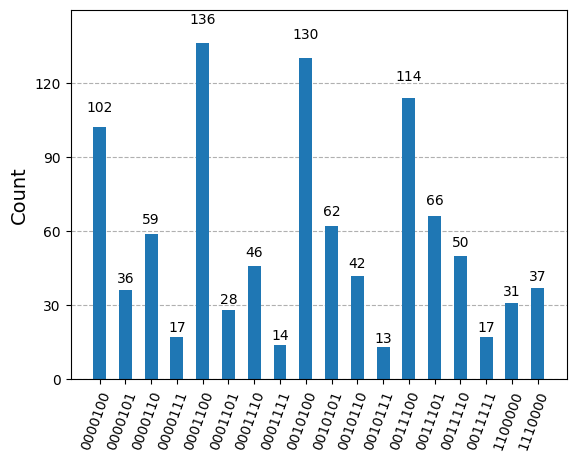

In [592]:
circuit = transpile(circ, simulator)
job = simulator.run(circuit, shots=1000)
result = job.result()

#print(f'backend: {result.backend_name}')
counts = result.get_counts()
print(counts)
sorted_counts = dict(sorted(result.get_counts().items()))
# sorted_counts = dict(sorted(result.get_counts().items(), reverse=True))
print(sorted_counts)
from qiskit.visualization import plot_histogram
print("Number of unique outcomes:", len(counts))
print('complexity:', complexity)
# Plot the histogram of the counts
plot_histogram(counts)
#'0101010111'

In [593]:


def is_satisfiable(clauses, num_vars):
    """
    Find all satisfying assignments for a Boolean SAT problem in CNF.

    Args:
        clauses (list of list of int): Each clause is a list of integers, where
            positive means the variable, negative means its negation.
        num_vars (int): Number of variables.

    Returns:
        list of str: Each string is a satisfying assignment as a bitstring.
    """
    solutions = []
    for assignment in itertools.product([False, True], repeat=num_vars):
        satisfied = True
        for clause in clauses:
            clause_satisfied = False
            for literal in clause:
                var_idx = abs(literal) - 1
                value = assignment[var_idx]
                if (literal > 0 and value) or (literal < 0 and not value):
                    clause_satisfied = True
                    break
            if not clause_satisfied:
                satisfied = False
                break
        if satisfied:
            bitstring = ''.join(str(int(bit)) for bit in assignment)
            solutions.append(bitstring)
    return solutions



In [594]:
s = is_satisfiable(Bfunc, n)
# s, len(s)

In [595]:
# Convert s (list of solutions) to bitstrings
s_bitstrings = set(bitstring[::-1] for bitstring in s)

# Keys present in counts but not in s
counts_keys = set(counts.keys())
diff_counts_not_in_s = counts_keys - s_bitstrings

# Keys present in s but not in counts
diff_s_not_in_counts = s_bitstrings - counts_keys

print("Counts keys :", sorted(counts_keys))
print("S bitstrings :", sorted(s_bitstrings))
print("Keys in counts but not in s:", diff_counts_not_in_s)
print("Keys in s but not in counts:", diff_s_not_in_counts)
print('num_clauses', len(Bfunc), 'complexity:', complexity)
print(Bfunc)
print(len(counts_keys), len(s_bitstrings))
# if complexity is not None:
print("Complexity per clause:", cxcount / len(Bfunc))
# else:
#     print(None)
len(diff_counts_not_in_s), len(diff_s_not_in_counts), complexity


Counts keys : ['0000100', '0000101', '0000110', '0000111', '0001100', '0001101', '0001110', '0001111', '0010100', '0010101', '0010110', '0010111', '0011100', '0011101', '0011110', '0011111', '1100000', '1110000']
S bitstrings : ['0000100', '0000101', '0000110', '0000111', '0001100', '0001101', '0001110', '0001111', '0010100', '0010101', '0010110', '0010111', '0011100', '0011101', '0011110', '0011111', '1100000', '1110000']
Keys in counts but not in s: set()
Keys in s but not in counts: set()
num_clauses 13 complexity: 45
[[-1, 3], [-2, -7], [-6, 7], [1, 3, -4], [1, 3, 6], [-1, 5, -6], [-3, -6, -7], [-3, 6, -7], [-1, 5, 6, -7], [3, 4, -6, 7], [-1, 2, 3, 4, -6], [1, 2, 3, -4, 7], [-2, 3, -4, 5, 6, -7]]
18 18
Complexity per clause: 3.4615384615384617


(0, 0, 45)